In [1]:
from numpy import genfromtxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import butter, lfilter, freqz
from scipy.fft import fft, fftfreq, ifft
from scipy.interpolate import interp1d 
import math

In [2]:
EKG_FRE = 2048
time = 50
order = 6
fs = 30.0       
cutoff = 0.5
data_count = EKG_FRE*time

In [3]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [14]:
b, a = butter_lowpass(cutoff, fs, order)

dataPath = 'AbnormalData/RX33/'
# Sort後資料不能用 EKG資料有到300多?
# dataPath = 'Data/EKG_Sort/N1_'

pre_data = genfromtxt(dataPath + 'VR_1_PreTest_EKG.csv', delimiter=',')
pre_ekg_data = pre_data[:,1]
# VR_data = genfromtxt(dataPath + 'VR_1_VRTest_EKG.csv', delimiter=',')
# VR_ekg_data = VR_data[:,1]
post_data = genfromtxt(dataPath + 'VR_1_PostTest_EKG.csv', delimiter=',')
post_ekg_data = post_data[:,1]

pre_ekg_data = pre_ekg_data[pre_ekg_data > -100]
# VR_ekg_data = VR_ekg_data[VR_ekg_data > -100]
post_ekg_data = post_ekg_data[post_ekg_data > -100]

pre_ekg_test = pre_ekg_data[:data_count]
# VR_ekg_test = VR_ekg_data[:data_count]
post_ekg_test = post_ekg_data[:data_count]

pre_data = butter_lowpass_filter(pre_ekg_test, cutoff, fs, order)
# VR_data = butter_lowpass_filter(VR_ekg_test, cutoff, fs, order)
post_data = butter_lowpass_filter(post_ekg_test, cutoff, fs, order)

pre_x = np.arange(data_count)/EKG_FRE
# VR_x = np.arange(data_count)/EKG_FRE
post_x = np.arange(data_count)/EKG_FRE

hrw = 0.75
fs = 2048

pre_pddata = pd.DataFrame(pre_data, columns = ['data'])
# VR_pddata = pd.DataFrame(VR_data, columns = ['data'])
post_pddata = pd.DataFrame(post_data, columns = ['data'])

pre_mov_avg = pre_pddata['data'].rolling(int(hrw*fs)).mean()
# VR_mov_avg = VR_pddata['data'].rolling(int(hrw*fs)).mean()
post_mov_avg = post_pddata['data'].rolling(int(hrw*fs)).mean()

pre_avg_hr = (np.mean(pre_pddata.data))
pre_mov_avg = [pre_avg_hr if math.isnan(x) else x for x in pre_mov_avg]
pre_mov_avg = [x+200 for x in pre_mov_avg] 
#將平均值提高 20% 以防止繼發性心臟收縮受到干擾，在第 2 部分中，我們將動態執行此操作
pre_pddata['hart_rollingmean'] = pre_mov_avg
# VR_avg_hr = (np.mean(VR_pddata.data))
# VR_mov_avg = [VR_avg_hr if math.isnan(x) else x for x in VR_mov_avg]
# VR_mov_avg = [x+200 for x in VR_mov_avg] 
#將平均值提高 20% 以防止繼發性心臟收縮受到干擾，在第 2 部分中，我們將動態執行此操作
# VR_pddata['hart_rollingmean'] = VR_mov_avg
post_avg_hr = (np.mean(post_pddata.data))
post_mov_avg = [post_avg_hr if math.isnan(x) else x for x in post_mov_avg]
post_mov_avg = [x+200 for x in post_mov_avg] 
#將平均值提高 20% 以防止繼發性心臟收縮受到干擾，在第 2 部分中，我們將動態執行此操作
post_pddata['hart_rollingmean'] = post_mov_avg

window = [] #記錄每一輪ROI範圍
pre_peaklist = [] #紀錄最高點位置
listpos = 0

for datapoint in pre_pddata.data:
    pre_rollingmean = pre_pddata.hart_rollingmean[listpos]
    if (datapoint < pre_rollingmean) and (len(window) < 1): 
	#未檢測到R-complex activity(因為len(window) < 1，所以目前沒有要檢查的ROI)
        listpos += 1
    elif (datapoint > pre_rollingmean): #信號在平均之上，標記為ROI
        window.append(datapoint)
        listpos += 1
    else: #當信號將要掉到平均之下且等於平均的那一刻，回頭去找ROI範圍中最高的一點
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) 
		#標記peak的位置
        pre_peaklist.append(beatposition) 
        window = [] #重置window
        listpos += 1

# window = [] #記錄每一輪ROI範圍
# VR_peaklist = [] #紀錄最高點位置
# listpos = 0

# for datapoint in VR_pddata.data:
#     VR_rollingmean = VR_pddata.hart_rollingmean[listpos]
#     if (datapoint < VR_rollingmean) and (len(window) < 1): 
# 	#未檢測到R-complex activity(因為len(window) < 1，所以目前沒有要檢查的ROI)
#         listpos += 1
#     elif (datapoint > VR_rollingmean): #信號在平均之上，標記為ROI
#         window.append(datapoint)
#         listpos += 1
#     else: #當信號將要掉到平均之下且等於平均的那一刻，回頭去找ROI範圍中最高的一點
#         maximum = max(window)
#         beatposition = listpos - len(window) + (window.index(max(window))) 
# 		#標記peak的位置
#         VR_peaklist.append(beatposition) 
#         window = [] #重置window
#         listpos += 1

window = [] #記錄每一輪ROI範圍
post_peaklist = [] #紀錄最高點位置
listpos = 0

for datapoint in post_pddata.data:
    post_rollingmean = post_pddata.hart_rollingmean[listpos]
    if (datapoint < post_rollingmean) and (len(window) < 1): 
	#未檢測到R-complex activity(因為len(window) < 1，所以目前沒有要檢查的ROI)
        listpos += 1
    elif (datapoint > post_rollingmean): #信號在平均之上，標記為ROI
        window.append(datapoint)
        listpos += 1
    else: #當信號將要掉到平均之下且等於平均的那一刻，回頭去找ROI範圍中最高的一點
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) 
		#標記peak的位置
        post_peaklist.append(beatposition) 
        window = [] #重置window
        listpos += 1

pre_RR_list = []
pre_cnt = 0
# VR_RR_list = []
# VR_cnt = 0
post_RR_list = []
post_cnt = 0

while (pre_cnt < (len(pre_peaklist)-1)):
    RR_interval = (pre_peaklist[pre_cnt+1] - pre_peaklist[pre_cnt]) #計算兩點距離
    ms_dist = ((RR_interval / fs) * 1000.0) #轉換距離為時間單位
    pre_RR_list.append(ms_dist)
    pre_cnt += 1
# while (VR_cnt < (len(VR_peaklist)-1)):
#     RR_interval = (VR_peaklist[VR_cnt+1] - VR_peaklist[VR_cnt]) #計算兩點距離
#     ms_dist = ((RR_interval / fs) * 1000.0) #轉換距離為時間單位
#     VR_RR_list.append(ms_dist)
#     VR_cnt += 1
while (post_cnt < (len(post_peaklist)-1)):
    RR_interval = (post_peaklist[post_cnt+1] - post_peaklist[post_cnt]) #計算兩點距離
    ms_dist = ((RR_interval / fs) * 1000.0) #轉換距離為時間單位
    post_RR_list.append(ms_dist)
    post_cnt += 1

pre_bpm = 60000 / np.mean(pre_RR_list)
# VR_bpm = 60000 / np.mean(VR_RR_list)
post_bpm = 60000 / np.mean(post_RR_list)
#60000 ms (1 minute) / average R-R interval of signal
print("PreTest EKG：")
print("Average Heart Beat is: %.01f" %pre_bpm) 

pre_RR_diff = [] #上述之第三點的部分
pre_RR_sqdiff = [] #上述之第四點的部分
pre_cnt = 1 

while (pre_cnt < (len(pre_RR_list)-1)): 
    pre_RR_diff.append(abs(pre_RR_list[pre_cnt] - pre_RR_list[pre_cnt+1])) #計算連續 R-R 區間之間的差
    pre_RR_sqdiff.append(math.pow(pre_RR_list[pre_cnt] - pre_RR_list[pre_cnt+1], 2)) #計算平方差
    pre_cnt += 1

#print(RR_diff, RR_sqdiff)
pre_ibi = np.mean(pre_RR_list) # Inter Beat Interval
print("IBI:", pre_ibi)

pre_sdnn = np.std(pre_RR_list) #R-R 區間的標準差
print("SDNN:", pre_sdnn)

pre_sdsd = np.std(pre_RR_diff) #所有後續 R-R 區間之間差異的標準差
print("SDSD:", pre_sdsd)

pre_rmssd = np.sqrt(np.mean(pre_RR_sqdiff)) #平方差列表的均值的根
print("RMSSD:", pre_rmssd)

pre_nn20 = [x for x in pre_RR_diff if (x>20)] 
pre_nn50 = [x for x in pre_RR_diff if (x>50)] #創建超過 20、50 的所有值的列表
pre_pnn20 = float(len(pre_nn20)) / float(len(pre_RR_diff)) 
pre_pnn50 = float(len(pre_nn50)) / float(len(pre_RR_diff))
#計算NN20、NN50區間佔所有區間的比例
print("pNN20, pNN50:", pre_pnn20, pre_pnn50)


pre_RR_x = pre_peaklist[1:] #刪除第一個位置，因為第一個間隔分配給第二個節拍
pre_RR_y = pre_RR_list #Y 值等於區間長度
pre_RR_x_new = np.linspace(pre_RR_x[0],pre_RR_x[-1],pre_RR_x[-1]) 
#從第二個峰值開始創建均勻間隔的時間線，其端點和長度等於最後一個峰值的位置
pre_f = interp1d(pre_RR_x, pre_RR_y, kind='cubic') 

pre_n = len(pre_pddata.data) 
pre_frq = np.fft.fftfreq(len(pre_pddata.data), d=((1/fs))) #將 bin 劃分為頻率類別
pre_frq = pre_frq[range(int(pre_n/2))] #獲取頻率範圍的一側

#FFT
pre_Y = np.fft.fft(pre_f(pre_RR_x_new))/pre_n #計算 FFT
pre_Y = pre_Y[range(int(pre_n/2))] #回傳 FFT 的一側

pre_lf = np.trapz(abs(pre_Y[(pre_frq>=0.04) & (pre_frq<=0.15)])) 
#Sx 介於 0.04 和 0.15Hz (LF) 之間的 lice 頻譜，並使用 NumPy 的trapz函數找到該區域
print("LF:", pre_lf)

pre_hf = np.trapz(abs(pre_Y[(pre_frq>=0.16) & (pre_frq<=0.5)])) #0.16-0.5Hz (HF)
print("HF:", pre_hf)
#plt.plot(RR_list, alpha=0.5, color='blue')

# print("\nVRTest EKG：")
# print("Average Heart Beat is: %.01f" %VR_bpm) 

# VR_RR_diff = [] #上述之第三點的部分
# VR_RR_sqdiff = [] #上述之第四點的部分
# VR_cnt = 1 

# while (VR_cnt < (len(VR_RR_list)-1)): 
#     VR_RR_diff.append(abs(VR_RR_list[VR_cnt] - VR_RR_list[VR_cnt+1])) #計算連續 R-R 區間之間的差
#     VR_RR_sqdiff.append(math.pow(VR_RR_list[VR_cnt] - VR_RR_list[VR_cnt+1], 2)) #計算平方差
#     VR_cnt += 1

# #print(RR_diff, RR_sqdiff)
# VR_ibi = np.mean(VR_RR_list) # Inter Beat Interval
# print("IBI:", VR_ibi)

# VR_sdnn = np.std(VR_RR_list) #R-R 區間的標準差
# print("SDNN:", VR_sdnn)

# VR_sdsd = np.std(VR_RR_diff) #所有後續 R-R 區間之間差異的標準差
# print("SDSD:", VR_sdsd)

# VR_rmssd = np.sqrt(np.mean(VR_RR_sqdiff)) #平方差列表的均值的根
# print("RMSSD:", VR_rmssd)

# VR_nn20 = [x for x in VR_RR_diff if (x>20)] 
# VR_nn50 = [x for x in VR_RR_diff if (x>50)] #創建超過 20、50 的所有值的列表
# VR_pnn20 = float(len(VR_nn20)) / float(len(VR_RR_diff)) 
# VR_pnn50 = float(len(VR_nn50)) / float(len(VR_RR_diff))
# #計算NN20、NN50區間佔所有區間的比例
# print("pNN20, pNN50:", VR_pnn20, VR_pnn50)


# VR_RR_x = VR_peaklist[1:] #刪除第一個位置，因為第一個間隔分配給第二個節拍
# VR_RR_y = VR_RR_list #Y 值等於區間長度
# VR_RR_x_new = np.linspace(VR_RR_x[0],VR_RR_x[-1],VR_RR_x[-1]) 
# #從第二個峰值開始創建均勻間隔的時間線，其端點和長度等於最後一個峰值的位置
# VR_f = interp1d(VR_RR_x, VR_RR_y, kind='cubic') 

# VR_n = len(VR_pddata.data) 
# VR_frq = np.fft.fftfreq(len(VR_pddata.data), d=((1/fs))) #將 bin 劃分為頻率類別
# VR_frq = VR_frq[range(int(VR_n/2))] #獲取頻率範圍的一側

# #FFT
# VR_Y = np.fft.fft(VR_f(VR_RR_x_new))/VR_n #計算 FFT
# VR_Y = VR_Y[range(int(VR_n/2))] #回傳 FFT 的一側

# VR_lf = np.trapz(abs(VR_Y[(VR_frq>=0.04) & (VR_frq<=0.15)])) 
# #Sx 介於 0.04 和 0.15Hz (LF) 之間的 lice 頻譜，並使用 NumPy 的trapz函數找到該區域
# print("LF:", VR_lf)

# VR_hf = np.trapz(abs(VR_Y[(VR_frq>=0.16) & (VR_frq<=0.5)])) #0.16-0.5Hz (HF)
# print("HF:", VR_hf)
# #plt.plot(RR_list, alpha=0.5, color='blue')

print("\nPostTest EKG：")
print("Average Heart Beat is: %.01f" %post_bpm) 

post_RR_diff = [] #上述之第三點的部分
post_RR_sqdiff = [] #上述之第四點的部分
post_cnt = 1 

while (post_cnt < (len(post_RR_list)-1)): 
    post_RR_diff.append(abs(post_RR_list[post_cnt] - post_RR_list[post_cnt+1])) #計算連續 R-R 區間之間的差
    post_RR_sqdiff.append(math.pow(post_RR_list[post_cnt] - post_RR_list[post_cnt+1], 2)) #計算平方差
    post_cnt += 1

#print(RR_diff, RR_sqdiff)
post_ibi = np.mean(post_RR_list) # Inter Beat Interval
print("IBI:", post_ibi)

post_sdnn = np.std(post_RR_list) #R-R 區間的標準差
print("SDNN:", post_sdnn)

post_sdsd = np.std(post_RR_diff) #所有後續 R-R 區間之間差異的標準差
print("SDSD:", post_sdsd)

post_rmssd = np.sqrt(np.mean(post_RR_sqdiff)) #平方差列表的均值的根
print("RMSSD:", post_rmssd)

post_nn20 = [x for x in post_RR_diff if (x>20)] 
post_nn50 = [x for x in post_RR_diff if (x>50)] #創建超過 20、50 的所有值的列表
post_pnn20 = float(len(post_nn20)) / float(len(post_RR_diff)) 
post_pnn50 = float(len(post_nn50)) / float(len(post_RR_diff))
#計算NN20、NN50區間佔所有區間的比例
print("pNN20, pNN50:", post_pnn20, post_pnn50)


post_RR_x = post_peaklist[1:] #刪除第一個位置，因為第一個間隔分配給第二個節拍
post_RR_y = post_RR_list #Y 值等於區間長度
post_RR_x_new = np.linspace(post_RR_x[0],post_RR_x[-1],post_RR_x[-1]) 
#從第二個峰值開始創建均勻間隔的時間線，其端點和長度等於最後一個峰值的位置
post_f = interp1d(post_RR_x, post_RR_y, kind='cubic') 

post_n = len(post_pddata.data) 
post_frq = np.fft.fftfreq(len(post_pddata.data), d=((1/fs))) #將 bin 劃分為頻率類別
post_frq = post_frq[range(int(post_n/2))] #獲取頻率範圍的一側

#FFT
post_Y = np.fft.fft(post_f(post_RR_x_new))/post_n #計算 FFT
post_Y = post_Y[range(int(post_n/2))] #回傳 FFT 的一側

post_lf = np.trapz(abs(post_Y[(post_frq>=0.04) & (post_frq<=0.15)])) 
#Sx 介於 0.04 和 0.15Hz (LF) 之間的 lice 頻譜，並使用 NumPy 的trapz函數找到該區域
print("LF:", post_lf)

post_hf = np.trapz(abs(post_Y[(post_frq>=0.16) & (post_frq<=0.5)])) #0.16-0.5Hz (HF)
print("HF:", post_hf)
#plt.plot(RR_list, alpha=0.5, color='blue')

PreTest EKG：
Average Heart Beat is: 66.5
IBI: 901.7876519097222
SDNN: 1615.9622545143905
SDSD: 2020.0615113626752
RMSSD: 2399.612618368992
pNN20, pNN50: 0.9411764705882353 0.8235294117647058
LF: 10836.434101474453
HF: 8832.228543393516

PostTest EKG：
Average Heart Beat is: 66.6
IBI: 900.6125710227273
SDNN: 74.68499692358358
SDSD: 19.595369639583403
RMSSD: 32.88087259094143
pNN20, pNN50: 0.5471698113207547 0.1320754716981132
LF: 68.57708382358614
HF: 46.62011587942364


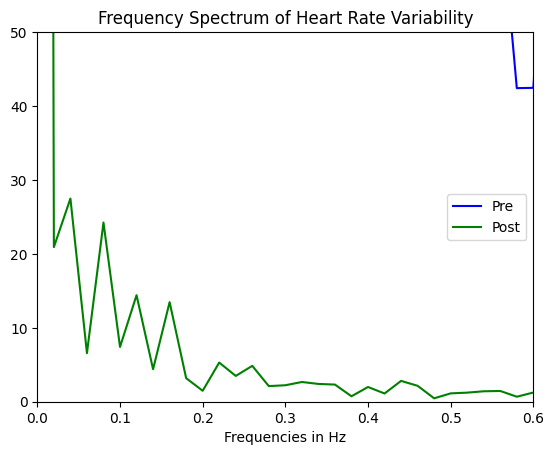

In [27]:
#Plot
plt.title("Frequency Spectrum of Heart Rate Variability")
plt.xlim(0,0.6) 
#將 X 軸限制為感興趣的頻率（0-0.6Hz 可見性，我們對 0.04-0.5 感興趣）
plt.ylim(0, 50)
plt.plot(pre_frq, abs(pre_Y), color='blue')
# plt.plot(VR_frq, abs(VR_Y), color='red')
plt.plot(post_frq, abs(post_Y), color='green')
# plt.legend(['Pre', 'VR', 'Post'])
plt.legend(['Pre', 'Post'])
plt.xlabel("Frequencies in Hz")

plt.show()

In [ ]:
# import xlwt
# file = xlwt.Workbook('encoding = utf-8')
# sheet1 = file.add_sheet('sheet1', cell_overwrite_ok = True)

# sheet1.write(0, 0, "pre_RR_list")
# sheet1.write(0, 1, "pre_RR_diff")

# for i in range(len(pre_RR_list)):
#     sheet1.write(i+1, 0, pre_RR_list[i])

# for j in range(len(pre_RR_diff)):
#     sheet1.write(j+1, 1, pre_RR_diff[j])

# file.save('RRI.xls')

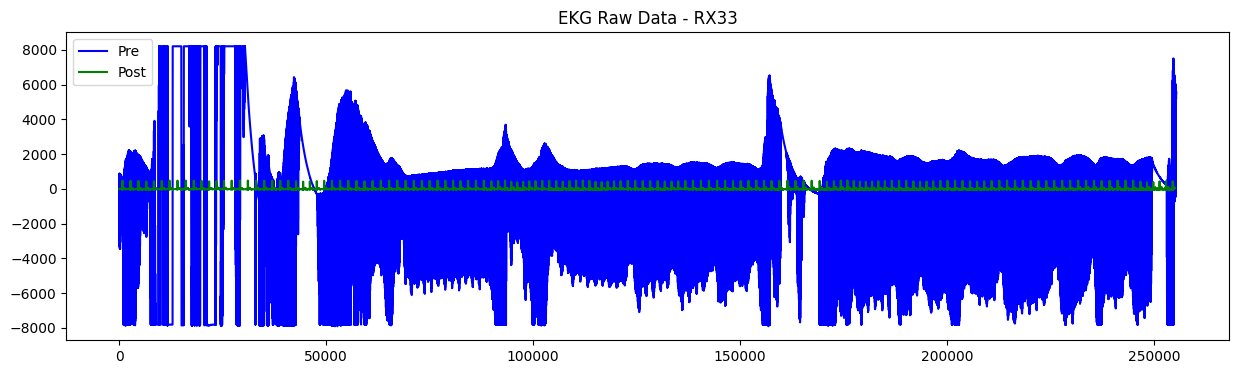

In [24]:
#Plot
plt.figure(figsize=(15,4))
plt.title("EKG Raw Data - " + "RX33")
pre_ekg_rawdata = pd.read_csv("AbnormalData/RX33/VR_1_PreTest_EKG.csv",  names=['TimeStamp', 'EKGdata'])
post_ekg_rawdata = pd.read_csv("AbnormalData/RX33/VR_1_PostTest_EKG.csv",  names=['TimeStamp', 'EKGdata'])
# plt.xlim(0,25000) # 筆數
# plt.ylim(0, 50) # 大小
plt.plot(pre_ekg_rawdata.index, pre_ekg_rawdata['EKGdata'], color='blue')
plt.plot(post_ekg_rawdata.index, post_ekg_rawdata['EKGdata'], color='green')
plt.legend(['Pre','Post'])
# plt.xlabel("Time")

plt.show()

In [ ]:
b, a = butter_lowpass(cutoff, fs, order)

dataPath = 'Data/'

pre_data = genfromtxt(dataPath + 'result_pcjson.com.csv', delimiter=',')
pre_ekg_data = pre_data['heartRateVariability']

# pre_ekg_data = pre_ekg_data[pre_ekg_data > -100]

pre_ekg_test = pre_ekg_data[:data_count]

pre_data = butter_lowpass_filter(pre_ekg_test, cutoff, fs, order)

pre_x = np.arange(data_count)/EKG_FRE

hrw = 0.75
fs = 2048

pre_pddata = pd.DataFrame(pre_data, columns = ['data'])

pre_mov_avg = pre_pddata['data'].rolling(int(hrw*fs)).mean()

pre_avg_hr = (np.mean(pre_pddata.data))
pre_mov_avg = [pre_avg_hr if math.isnan(x) else x for x in pre_mov_avg]
pre_mov_avg = [x+200 for x in pre_mov_avg] 
#將平均值提高 20% 以防止繼發性心臟收縮受到干擾，在第 2 部分中，我們將動態執行此操作
pre_pddata['hart_rollingmean'] = pre_mov_avg

window = [] #記錄每一輪ROI範圍
pre_peaklist = [] #紀錄最高點位置
listpos = 0

for datapoint in pre_pddata.data:
    pre_rollingmean = pre_pddata.hart_rollingmean[listpos]
    if (datapoint < pre_rollingmean) and (len(window) < 1): 
	#未檢測到R-complex activity(因為len(window) < 1，所以目前沒有要檢查的ROI)
        listpos += 1
    elif (datapoint > pre_rollingmean): #信號在平均之上，標記為ROI
        window.append(datapoint)
        listpos += 1
    else: #當信號將要掉到平均之下且等於平均的那一刻，回頭去找ROI範圍中最高的一點
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) 
		#標記peak的位置
        pre_peaklist.append(beatposition) 
        window = [] #重置window
        listpos += 1

pre_RR_list = []
pre_cnt = 0

while (pre_cnt < (len(pre_peaklist)-1)):
    RR_interval = (pre_peaklist[pre_cnt+1] - pre_peaklist[pre_cnt]) #計算兩點距離
    ms_dist = ((RR_interval / fs) * 1000.0) #轉換距離為時間單位
    pre_RR_list.append(ms_dist)
    pre_cnt += 1

pre_bpm = 60000 / np.mean(pre_RR_list)
#60000 ms (1 minute) / average R-R interval of signal
print("PreTest EKG：")
print("Average Heart Beat is: %.01f" %pre_bpm) 

pre_RR_diff = [] #上述之第三點的部分
pre_RR_sqdiff = [] #上述之第四點的部分
pre_cnt = 1 

while (pre_cnt < (len(pre_RR_list)-1)): 
    pre_RR_diff.append(abs(pre_RR_list[pre_cnt] - pre_RR_list[pre_cnt+1])) #計算連續 R-R 區間之間的差
    pre_RR_sqdiff.append(math.pow(pre_RR_list[pre_cnt] - pre_RR_list[pre_cnt+1], 2)) #計算平方差
    pre_cnt += 1

#print(RR_diff, RR_sqdiff)
pre_ibi = np.mean(pre_RR_list) # Inter Beat Interval
print("IBI:", pre_ibi)

pre_sdnn = np.std(pre_RR_list) #R-R 區間的標準差
print("SDNN:", pre_sdnn)

pre_sdsd = np.std(pre_RR_diff) #所有後續 R-R 區間之間差異的標準差
print("SDSD:", pre_sdsd)

pre_rmssd = np.sqrt(np.mean(pre_RR_sqdiff)) #平方差列表的均值的根
print("RMSSD:", pre_rmssd)

pre_nn20 = [x for x in pre_RR_diff if (x>20)] 
pre_nn50 = [x for x in pre_RR_diff if (x>50)] #創建超過 20、50 的所有值的列表
pre_pnn20 = float(len(pre_nn20)) / float(len(pre_RR_diff)) 
pre_pnn50 = float(len(pre_nn50)) / float(len(pre_RR_diff))
#計算NN20、NN50區間佔所有區間的比例
print("pNN20, pNN50:", pre_pnn20, pre_pnn50)


pre_RR_x = pre_peaklist[1:] #刪除第一個位置，因為第一個間隔分配給第二個節拍
pre_RR_y = pre_RR_list #Y 值等於區間長度
pre_RR_x_new = np.linspace(pre_RR_x[0],pre_RR_x[-1],pre_RR_x[-1]) 
#從第二個峰值開始創建均勻間隔的時間線，其端點和長度等於最後一個峰值的位置
pre_f = interp1d(pre_RR_x, pre_RR_y, kind='cubic') 

pre_n = len(pre_pddata.data) 
pre_frq = np.fft.fftfreq(len(pre_pddata.data), d=((1/fs))) #將 bin 劃分為頻率類別
pre_frq = pre_frq[range(int(pre_n/2))] #獲取頻率範圍的一側

#FFT
pre_Y = np.fft.fft(pre_f(pre_RR_x_new))/pre_n #計算 FFT
pre_Y = pre_Y[range(int(pre_n/2))] #回傳 FFT 的一側

pre_lf = np.trapz(abs(pre_Y[(pre_frq>=0.04) & (pre_frq<=0.15)])) 
#Sx 介於 0.04 和 0.15Hz (LF) 之間的 lice 頻譜，並使用 NumPy 的trapz函數找到該區域
print("LF:", pre_lf)

pre_hf = np.trapz(abs(pre_Y[(pre_frq>=0.16) & (pre_frq<=0.5)])) #0.16-0.5Hz (HF)
print("HF:", pre_hf)

#Plot
plt.title("Frequency Spectrum of Heart Rate Variability")
plt.xlim(0,0.6) 
#將 X 軸限制為感興趣的頻率（0-0.6Hz 可見性，我們對 0.04-0.5 感興趣）
plt.ylim(0, 50)
plt.plot(pre_frq, abs(pre_Y), color='blue')
plt.legend(['Pre', 'Post'])
plt.xlabel("Frequencies in Hz")

plt.show()